In [ ]:
!pip install datasets  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.0 MB/s eta 0:00:00


In [ ]:
!pip install numpy opencv-python pillow tensorflow keras imutils scikit-learn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Шаг 1: импорт основных библиотек

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

### 1. Функция для построения графика потерь при валидации модели и точности валидации

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# Шаг 2. Считывание и обработка данных

In [ ]:
from datasets import load_dataset
dataset = load_dataset('marmal88/skin_cancer')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/9577 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2492 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1285 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/marmal88___parquet/marmal88--skin_cancer-4d80d9330324f110/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Основываясь на информации, набор данных состоит из трех подмножеств: обучающее, валидационное и тестовое. Каждое подмножество содержит такие столбцы, как 'image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex' и 'localization'. Я предположу, что это задача классификации изображений с несколькими классами, где цель состоит в том, чтобы предсказать столбец "dx", который представляет диагноз или метку класса.

**train** - обучающая (на которой модель обучают)

**validation** - валидационная (для оценки переобученности модели, для оценки ошибки прогнозирования при выборе модели, для настройки гиперпараметров и выбора лучшей модели), показывает, как может повести себя модель с новыми данными

**test** - тестовая (для оценки работы готовой модели, для оценки ошибки обобщения для окончательной выбранной модели)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 9577
    })
    validation: Dataset({
        features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 2492
    })
    test: Dataset({
        features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 1285
    })
})

In [ ]:
import pandas as pd

train_dataset = dataset['validation']

train_df = pd.DataFrame(train_dataset)

train_df


image      image_id  \
0     <PIL.JpegImagePlugin.JpegImageFile image mode=...  ISIC_0024450   
1     <PIL.JpegImagePlugin.JpegImageFile image mode=...  ISIC_0024470   
2     <PIL.JpegImagePlugin.JpegImageFile image mode=...  ISIC_0024511   
3     <PIL.JpegImagePlugin.JpegImageFile image mode=...  ISIC_0024575   
4     <PIL.JpegImagePlugin.JpegImageFile image mode=...  ISIC_0024925   
...                                                 ...           ...   
2487  <PIL.JpegImagePlugin.JpegImageFile image mode=...  ISIC_0033092   
2488  <PIL.JpegImagePlugin.JpegImageFile image mode=...  ISIC_0033135   
2489  <PIL.JpegImagePlugin.JpegImageFile image mode=...  ISIC_0033254   
2490  <PIL.JpegImagePlugin.JpegImageFile image mode=...  ISIC_0033844   
2491  <PIL.JpegImagePlugin.JpegImageFile image mode=...  ISIC_0033991   

        lesion_id                 dx    dx_type   age     sex     localization  
0     HAM_0005505  actinic_keratoses      histo  50.0    male  upper extremity  
1     HAM_0006220  actinic_keratoses      histo  60.0    male  upper extremity  
2     HAM_0001505  actinic_keratoses      histo  55.0  female             face  
3     HAM_0004722  actinic_keratoses      histo  70.0  female  upper extremity  
4     HAM_0006592  actinic_keratoses      histo  75.0    male          abdomen  
...           ...                ...        ...   ...     ...              ...  
2487  HAM_0000494   vascular_lesions      histo  55.0    male  lower extremity  
2488  HAM_0004791   vascular_lesions      histo  80.0  female  lower extremity  
2489  HAM_0005878   vascular_lesions      histo  15.0    male            chest  
2490  HAM_0003480   vascular_lesions  consensus  70.0  female  lower extremity  
2491  HAM_0006852   vascular_lesions  consensus  45.0  female          abdomen  

[2492 rows x 8 columns]

# Шаг 4: Очистка данных

На этом шаге я проверяю наличие пропущенных значений и типа данных в каждом поле

In [ ]:
train_df.isnull().sum()

image            0
image_id         0
lesion_id        0
dx               0
dx_type          0
age             14
sex              0
localization     0
dtype: int64

In [ ]:
train_df['age'].fillna((train_df['age'].mean()), inplace=True)

In [ ]:
train_df.isnull().sum()

image           0
image_id        0
lesion_id       0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [ ]:
print(train_df.dtypes)

image            object
image_id         object
lesion_id        object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object


# Шаг 5: EDA

Здесь я рассматриваб различные особенности набора данных, их распределение и фактическое количество

На графике показано распределение 7 различных классов типов ячеек

<Axes: >

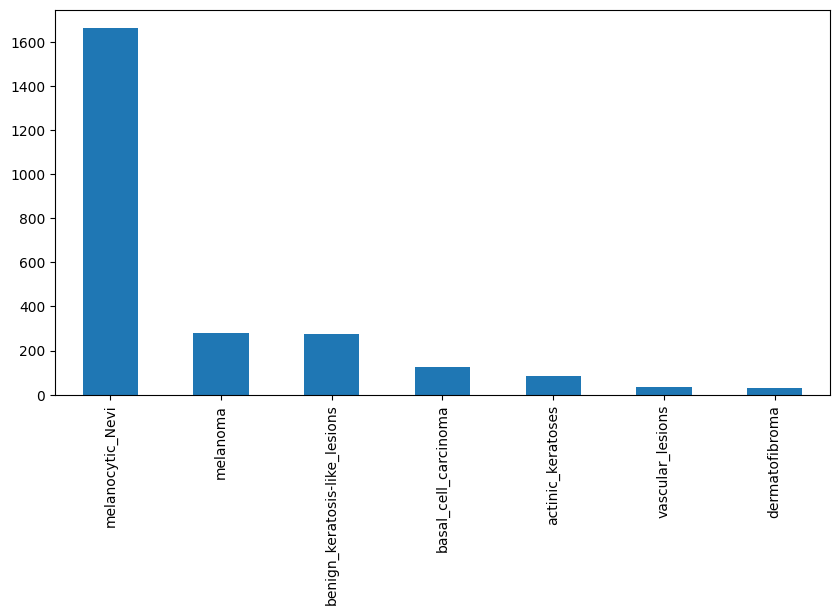

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
train_df['dx'].value_counts().plot(kind='bar', ax=ax1)

Из приведенного выше графика видно, что в этом наборе данных тип клеток меланецитарных невусов имеет очень большое количество экземпляров по сравнению с другими типами клеток

Построение поля технической проверки (ground truth), которое имеет тип dx_type, чтобы увидеть распределение его по 4 категориям, которые перечислены ниже :
1. Гистопатология (Histo): Гистопатологическая диагностика удаленных поражений была проведена специализированными дерматопатологами.
2. Конфокальная микроскопия: Отражательная конфокальная микроскопия - это метод визуализации in vivo с разрешением на уровне, близком к клеточному, и для некоторых лицевых изображений с предположением о сером мире всех обучающих изображений в лабораторном цветовом пространстве до и после ручных изменений гистограммы.
3. Последующее наблюдение: Если невусы, выявленные с помощью цифровой дерматоскопии, не показали никаких изменений в течение 3 последующих визитов или 1,5 лет, биологи приняли это как свидетельство биологической доброкачественности. Только невусы, но никакие другие доброкачественные диагнозы не были помечены таким образом, поскольку дерматологи обычно не отслеживают дерматофибромы, себорейные кератозы или сосудистые поражения.
4. Вывод: Для типичных доброкачественных случаев без гистопатологии или последующего наблюдения биологи дают экспертно-консенсусную оценку авторов PT и HK. Они применяли консенсусный ярлык только в том случае, если оба автора независимо ставили один и тот же однозначный доброкачественный диагноз. Поражения с таким типом первопричины обычно фотографировались в образовательных целях и не нуждались в дальнейшем наблюдении или биопсии для подтверждения.

<Axes: >

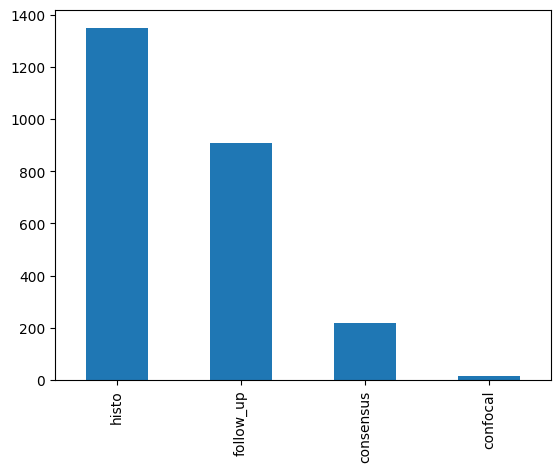

In [ ]:
train_df['dx_type'].value_counts().plot(kind='bar')

Построение графика распределения поля локализации

<Axes: >

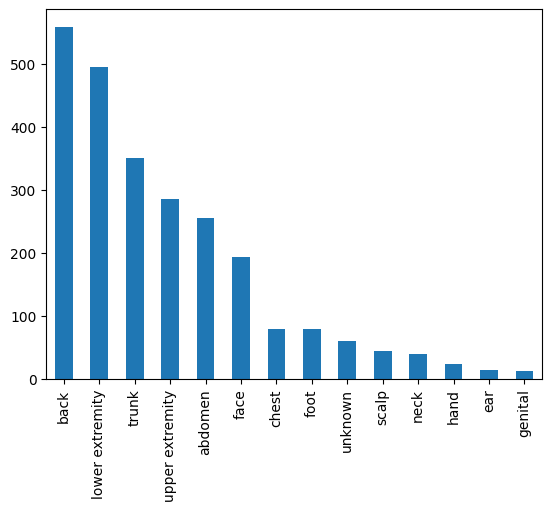

In [ ]:
train_df['localization'].value_counts().plot(kind='bar')

Похоже, что спина, нижние конечности, туловище и верхние конечности являются сильно пораженными раком кожи областями

Теперь проверем распределение по возрасту

<Axes: >

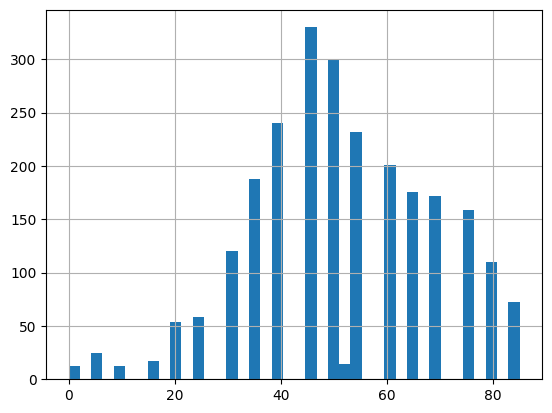

In [ ]:
train_df['age'].hist(bins=40)

По-видимому, существует больше случаев, когда пациенты имеют возраст от 30 до 60 лет

Теперь посмотрим на распределение мужчин и женщин

<Axes: >

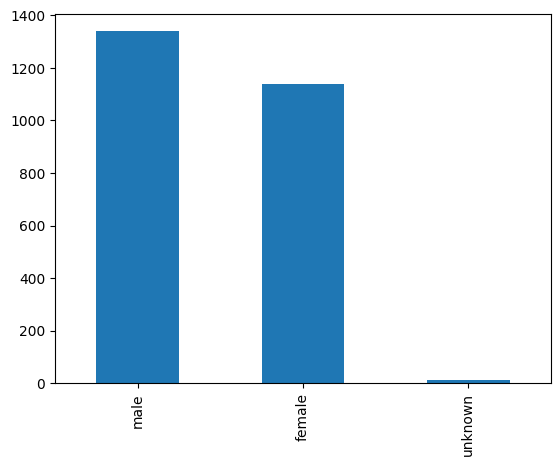

In [ ]:
train_df['sex'].value_counts().plot(kind='bar')

# Шаг 6: Отоброжение

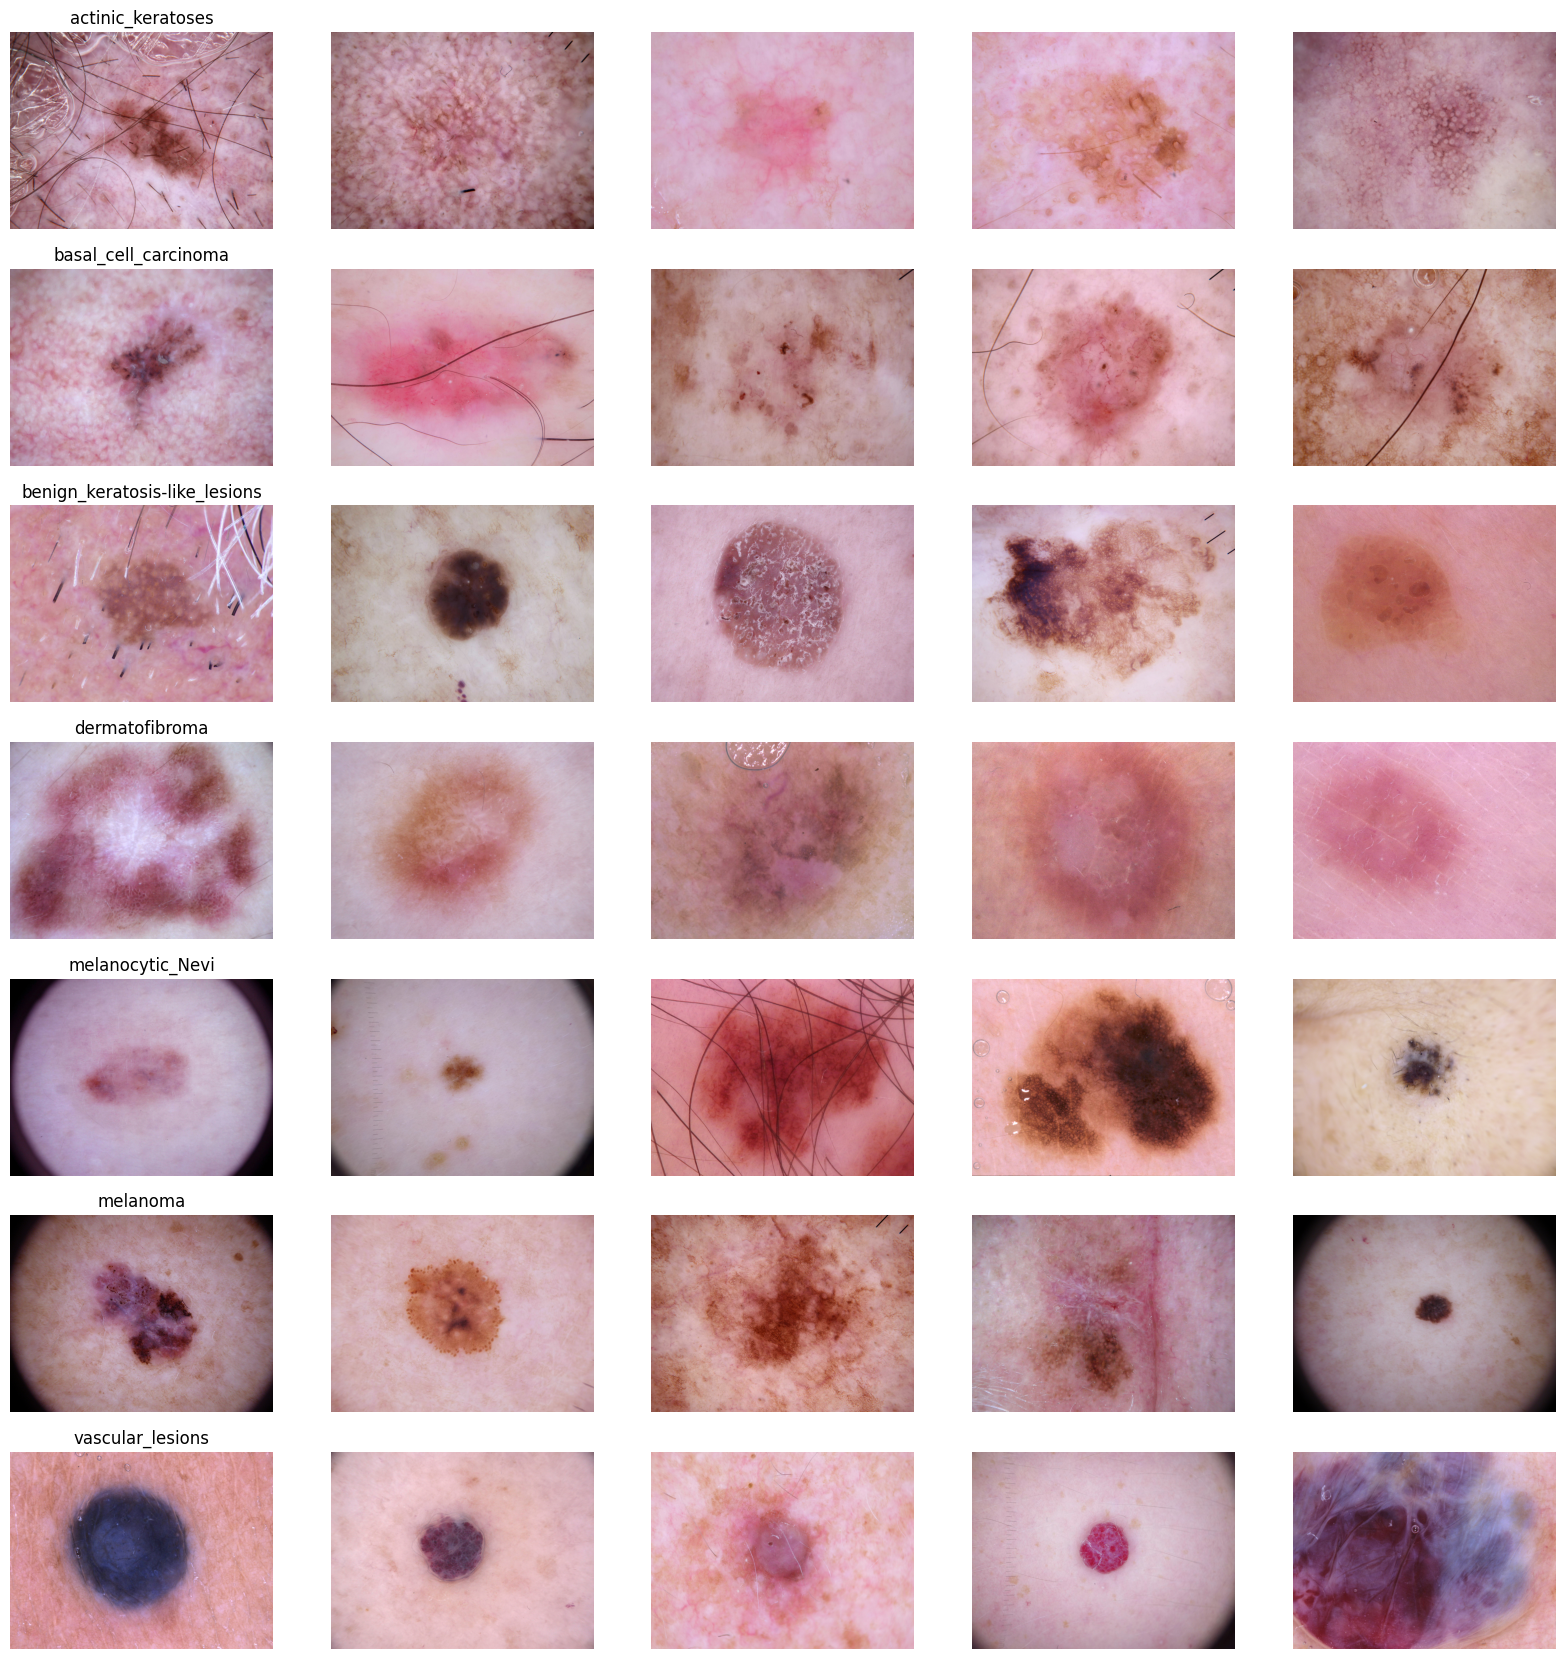

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         train_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Шаг 7: Разделение тренировочного теста

In [ ]:
features=train_df.drop(columns=['dx'],axis=1)
target=train_df['dx']

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

# Шаг 8: Нормализация

Я выбираю нормализовать x_train, x_test путем вычитания из средних значений и последующего деления на их стандартное отклонение.

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())


<ipython-input-16-c85f608096f3>:1: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x_train = np.asarray(x_train_o['image'].tolist())
<ipython-input-16-c85f608096f3>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.asarray(x_train_o['image'].tolist())
<ipython-input-16-c85f608096f3>:2: FutureWarning: The input object of type 'JpegImageFile' i

# Шаг 9: Кодирование этикетки

На этикетках указаны 7 различных классов типов рака кожи от 0 до 6. Нам нужно закодировать эти метки в один горячий вектор

In [ ]:
# Выполнение однократного кодирование меток
from sklearn.preprocessing import LabelEncoder

# Инициализирование LabelEncoder
label_encoder = LabelEncoder()

# Подгонка и преобразование меток учебных целей
y_train_encoded = label_encoder.fit_transform(y_train_o)

# Преобразование целевых меток теста с помощью встроенного labelencoder
y_test_encoded = label_encoder.transform(y_test_o)

# Применение однократного кодирования к закодированным меткам
y_train = to_categorical(y_train_encoded, num_classes=7)
y_test = to_categorical(y_test_encoded, num_classes=7)


# Шаг 10: Разделение обучения и валидации

Я решил разделить набор обучающих данных на две части: небольшая часть (10%) стала проверочным набором, по которому оценивается модель, а остальная часть (90%) используется для обучения модели.

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

# Шаг 11: Построение модели

# CNN

Я использовал последовательный API Keras, где вам нужно просто добавлять по одному слою за раз, начиная с входных данных.

Первый - это сверточный слой (Conv2D). Это похоже на набор обучаемых фильтров. Я решил установить 32 фильтра для двух первых слоев Conv2D и 64 фильтра для двух последних. Каждый фильтр преобразует часть изображения (определяемую размером ядра) с помощью фильтра ядра. Матрица фильтра ядра применяется ко всему изображению. Фильтры можно рассматривать как трансформацию изображения.

CNN может выделить из этих преобразованных изображений (карт объектов) объекты, которые полезны везде.

Вторым важным уровнем в CNN является уровень объединения (MaxPool2D). Этот слой просто действует как фильтр понижающей дискретизации. Он просматривает 2 соседних пикселя и выбирает максимальное значение. Они используются для снижения вычислительных затрат и в некоторой степени также для уменьшения переобучения. Мы должны выбрать размер пула (т.е. размер области, объединяемой каждый раз), чем больше размер пула, тем важнее понижающая дискретизация.

Комбинируя сверточный и объединяющий слои, CNN может комбинировать локальные объекты и изучать более глобальные особенности изображения.

Отсев - это метод регуляризации, при котором доля узлов в слое случайным образом игнорируется (устанавливая их значения равными нулю) для каждой обучающей выборки. Это случайным образом отбрасывает продвижение сети и вынуждает сеть изучать функции распределенным способом. Этот метод также улучшает обобщение и уменьшает переобучение.

"relu" - это выпрямитель (функция активации max(0,x). Функция активации выпрямителя используется для добавления нелинейности в сеть.

Слой сглаживания используется для преобразования конечных карт объектов в единый 1D-вектор. Этот шаг выравнивания необходим для того, чтобы вы могли использовать полностью подключенные слои после некоторых сверточных слоев / слоев maxpool. Он сочетает в себе все найденные локальные особенности предыдущих сверточных слоев.

В конце концов, я использовал функции в двух полностью связанных (плотных) слоях, которые являются просто искусственным классификатором нейронных сетей (ANN). На последнем слое (плотный(10,активация="softmax")) сеть выводит распределение вероятности для каждого класса.

In [ ]:
# Установка модели CNN
# моя архитектура CNN находится в -> [[Conv2D-> relu]*2 -> Максимальный пул 2D -> Выпадение]*2 -> Сглаживание -> Плотное -> Выпадение -> Выход
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 64)        36928     
                                                        

# Шаг 12: Настройка оптимизатора и отжигателя

Как только слои будут добавлены в модель, нужно настроить функцию оценки, функцию потерь и алгоритм оптимизации. Определяем функцию потерь, чтобы измерить, насколько плохо наша модель работает на изображениях с известными метками. Это частота ошибок между полученными метками и предсказанными. Используем специальную форму для категориальных классификаций (>2 классов), называемую "categorical_crossentropy". Самая важная функция - это оптимизатор. Эта функция будет итеративно улучшать параметры (фильтрует значения ядра, веса и смещение нейронов ...), чтобы минимизировать потери. Я выбрал Adam optimizer, потому что он сочетает в себе преимущества двух других расширений стохастического градиентного спуска. Конкретно:

Адаптивный градиентный алгоритм (AdaGrad), поддерживающий скорость обучения по каждому параметру, что повышает производительность при решении задач с разреженными градиентами (например, проблемы с естественным языком и компьютерным зрением).

Распространение среднеквадратичного значения (RMSProp), которое также поддерживает скорости обучения по каждому параметру, адаптированные на основе среднего значения последних значений градиентов для веса (например, насколько быстро он меняется). Это означает, что алгоритм хорошо справляется с оперативными и нестационарными задачами (например, с шумом).

Adam осознает преимущества как AdaGrad, так и RMSProp.

Adam - популярный алгоритм в области глубокого обучения, поскольку он быстро достигает хороших результатов.

Метрическая функция "точность" используется для оценки производительности нашей модели. Эта метрическая функция аналогична функции потерь, за исключением того, что результаты оценки метрики не используются при обучении модели (только для оценки).

In [ ]:
# Определение оптимизатоа
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Компилирование модели
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Установка отжигателя скорости обучения
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

Чтобы заставить оптимизатор сходиться быстрее и ближе всего к глобальному минимуму функции потерь, я использовал метод отжига скорости обучения (LR).

LR - это шаг, с помощью которого оптимизатор проходит через "ландшафт потерь". Чем выше LR, тем больше шаги и тем быстрее происходит сближение. Однако выборка очень плохая при высоком LR, и оптимизатор, вероятно, может попасть в локальные минимумы.

Лучше иметь снижающуюся скорость обучения во время обучения, чтобы эффективно достичь глобального минимума функции потерь.

Чтобы сохранить преимущество быстрого времени вычислений при высоком LR, я динамически уменьшал LR каждые X шагов (эпох) в зависимости от того, необходимо ли это (когда точность не повышается).

С помощью функции ReduceLROnPlateau из Keras.обратные вызовы я выбираю уменьшить LR наполовину, если точность не улучшается через 3 эпохи.

# Шаг 13: Подгонка модели

На этом этапе я, наконец, помещаю модель в x_train, y_train. На этом шаге я выбрал размер пакета 10 и 50 эпох, настолько маленький, насколько ваш размер пакета будет более эффективным для обучения вашей модели, и я выбрал 50 эпох, чтобы дать модели достаточное количество эпох для обучения

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Преобразование обучающих и проверочных изображения в массивы
x_train_array = np.array([img_to_array(img) for img in x_train])
x_validate_array = np.array([img_to_array(img) for img in x_validate])

# Нормализирование значения пикселей
x_train_normalized = x_train_array / 255.0
x_validate_normalized = x_validate_array / 255.0

# Подходит для модели
epochs = 50
batch_size = 10
history = model.fit(x_train_normalized, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_validate_normalized, y_validate),
                    verbose=1,
                    callbacks=[learning_rate_reduction])

# Шаг 14: Оценка модели

На этом шаге я проверяю точность тестирования и валидации модели, хотел построить матрицу путаницы, а также проверить количество неправильных классифицированных изображений каждого типа, но из-за минимальный памяти ОЗУ в Google Colab, код прерывается и приходится делать все заново и так по кругу. 